In [1]:
import os,sys,signal
import math

import pickle
import numpy as np                                       # fast vectors and matrices
import matplotlib.pyplot as plt                          # plotting
import argparse

import torch
from torch.nn.functional import conv1d, mse_loss
import torch.nn.functional as F
import torch.nn as nn
from nnAudio import Spectrogram
from time import time

# For the dataloading
from Dataset import MusicNet_Spec
from constants import *

from librosa import stft, load, cqt
from librosa.feature import melspectrogram
import glob
import tqdm
import soundfile
import numpy as np

# parser = argparse.ArgumentParser()
# parser.add_argument("resolution", type=int,help="Resolution for CQT:")
# args = parser.parse_args()


device = 'cuda:0'

In [2]:
batch_size = 16
resolution = 1
bins_per_octave = 12*resolution
n_bins = 88*resolution
network_factor = 4096//(88*resolution)

In [ ]:
for file in tqdm.tqdm(glob.glob('./data/train_data/*.wav')):
    audio, sr = soundfile.read(file, dtype=np.float32)
    spec = abs(cqt(audio, sr=44100, n_bins=n_bins, bins_per_octave=bins_per_octave, hop_length=512))
    np.save(file[:-3]+'spec',spec)

 48%|████▊     | 154/320 [25:18<22:38,  8.18s/it] 

In [7]:
start = time()
train_set = MusicNet_Spec(path='./data/', groups=['train'], sequence_length=327680, refresh=True)
loading_time = time()-start

Loading group train: 0it [00:00, ?it/s]

Loading 1 group of MusicNet_Spec at ./data/


Loading group train: 320it [01:23,  3.74it/s]


In [8]:
train_loader = torch.utils.data.DataLoader(train_set,batch_size=batch_size)

In [9]:
lr = 1e-4


Loss = torch.nn.BCELoss()
def L(yhatvar,y):
    return Loss(yhatvar,y) * 128/2

class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        f_kernal = 128//network_factor
        self.freq_cnn1 = torch.nn.Conv2d(1,4, (f_kernal,3), stride=(8,1), padding=1)
        self.freq_cnn2 = torch.nn.Conv2d(4,8, (f_kernal,3), stride=(8,1), padding=1)
        shape = self.shape_inference(f_kernal)
        self.bilstm = torch.nn.LSTM(8*shape, 8*shape, batch_first=True, bidirectional=True)
        self.pitch_classifier = torch.nn.Linear(shape*8*2, 88)

    def shape_inference(self, f_kernal):
        layer1 = (n_bins+2-(f_kernal))//8 + 1 
        layer2 = (layer1+2-(f_kernal))//8 + 1 
        return layer2        
        
    def forward(self,x):
        x = torch.log(x+1e-3)
        x = torch.relu(self.freq_cnn1(x.unsqueeze(1)))
        x = torch.relu(self.freq_cnn2(x))
        x, _ = self.bilstm(x.view(x.size(0), x.size(1)*x.size(2), x.size(3)).transpose(1,2))
        x = torch.sigmoid(self.pitch_classifier(x))
        
        return x
    
model = Model()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn  = torch.nn.BCELoss()


In [10]:
epoches = 50
times = []
loss_histroy = []
print("epoch\ttrain loss\ttime")
total_i = len(train_loader)
for e in range(epoches):
    running_loss = 0
    start = time()
    for idx, data in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model(data['audio'].to(device))
        loss = loss_fn(y_pred, data['frame'].to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()        
        
        print(f"Training {idx+1}/{total_i} batches\t Loss: {loss.item()}", end = '\r')
    time_used = time()-start
    times.append(time_used)
    print(' '*200, end='\r')
    print(f'{e+1}\t{running_loss/total_i:.6f}\t{time_used:.6f}')
    loss_histroy.append(running_loss/total_i)

epoch	train loss	time
1	0.692741	1.296670                                                                                                                                                                                     
2	0.687791	1.023066                                                                                                                                                                                     
3	0.683164	1.153029                                                                                                                                                                                     
4	0.678095	1.055359                                                                                                                                                                                     
5	0.672676	1.073807                                                                                                                                                           

42	0.156315	1.050587                                                                                                                                                                                    
43	0.154581	1.018626                                                                                                                                                                                    
44	0.153826	1.016709                                                                                                                                                                                    
45	0.151420	1.052085                                                                                                                                                                                    
46	0.152185	1.010567                                                                                                                                                                                

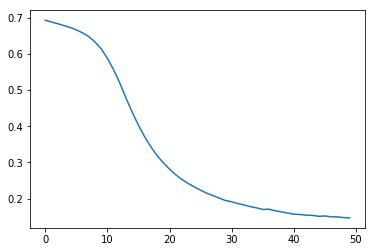

In [11]:
plt.plot(loss_histroy)

In [ ]:
librosa_result = {}

In [ ]:
librosa_result['loss_histroy'] = loss_histroy
librosa_result['time_histroy'] = times
librosa_result['loading_time'] = loading_time

In [ ]:
import pickle

In [ ]:
with open(f'./librosa_result_STFT-{n_fft}', 'wb') as f:
    pickle.dump(librosa_result,f)